In [1]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(".")
# os.environ["MAX_JOBS"] = "100"

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
torch.cuda.is_available()

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from src.vlstm_fwbw_v1.interface import vlstm_fwbw_torch_obw, vlstm_fwbw_cuda
from src.vlstm_fwbw_v1.interface import vlstm_fw_torch, vlstm_fw_cuda
from src.vlstm_fwbw_v1.interface import vlstm_bw_torch_obw, vlstm_bw_cuda

INCLUDE: ['/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC', '/home/max/miniconda3/envs/xlstmpt220cu121/include']
/home/max/myrepos/vlstm_cuda/src
/home/max/cpplibs/libtorch/lib:/usr/local/cuda-12.3/lib64:
/home/max/miniconda3/envs/xlstmpt220cu121/lib


Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/vlstm_fwbw_v1/build.ninja...
Building extension module vlstm_fwbw_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module vlstm_fwbw_v1...


## CUDA vLSTM forward backward

In [3]:
S = 8 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 8 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [4]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(0)
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.

# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S, 1) / 10.
# igs = torch.zeros((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

### match directly

In [5]:
hs_pt, n_pt, m_pt, _, matD_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)

In [6]:
dQs_pt, dKs_pt, dVs_pt, dIgs_pt, dFgs_pt, delta_D_pt, delta_Dtilde_pt, delta_fbar_pt, mat_P_pt, mat_R_pt = vlstm_bw_torch_obw(
    delta_Htilde=dHs,
    queries=qs,
    keys=ks,
    values=vs,
    igate_preact=igs,
    fgate_preact=fgs,
    var_n=n_pt,
    var_m=m_pt,
)


In [7]:
# cuda kernel
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)
dQs_cu, dKs_cu, dVs_cu, dIgs_cu, dFgs_cu, matC_cu, deltaDcsChunkArr_cu, deltaDcsVec_cu = vlstm_bw_cuda(
    mat_delta_H=dHs,
    mat_Q=qs,
    mat_K=ks,
    mat_V=vs,
    vec_igp=igs,
    vec_fgp=fgs,
    vec_n=n_cu,
    vec_m=m_cu,
)

before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [8]:
hs_cu2, n_cu2, m_cu2, matD_cu2 = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)
dQs_cu2, dKs_cu2, dVs_cu2, dIgs_cu2, dFgs_cu2, matC_cu2, deltaDcsChunkArr_cu2, deltaDcsVec_cu2 = vlstm_bw_cuda(
    mat_delta_H=dHs,
    mat_Q=qs,
    mat_K=ks,
    mat_V=vs,
    vec_igp=igs,
    vec_fgp=fgs,
    vec_n=n_cu2,
    vec_m=m_cu2,
)

before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [9]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}")
print(f"fw D match: {torch.allclose((matD_cu - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}")

print(f"delta Q match: {torch.allclose(dQs_cu, dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu - dQs_pt))}")
print(f"delta K match: {torch.allclose(dKs_cu, dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu - dKs_pt))}")
print(f"delta V match: {torch.allclose(dVs_cu, dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu - dVs_pt))}")
print(f"delta Igate match: {torch.allclose(dIgs_cu, dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu - dIgs_pt))}")
print(f"delta Fgate match: {torch.allclose(dFgs_cu, dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu - dFgs_pt))}")

print(f"mat R match: {torch.allclose(mat_R_pt, matC_cu, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(mat_R_pt - matC_cu))}")

fw hs match: True, max diff: 2.384185791015625e-07
fw n match: True
fw m match: True
fw D match: True
delta Q match: True, max diff: 1.52587890625e-05
delta K match: True, max diff: 1.049041748046875e-05
delta V match: True, max diff: 2.6226043701171875e-06
delta Igate match: True, max diff: 9.059906005859375e-06
delta Fgate match: True, max diff: 1.3113021850585938e-06
mat R match: True, max diff: 1.7881393432617188e-07


dKs diff:


(tensor([[[[ 1.1337,  1.4891,  4.3524, -0.9589, -0.8078, -1.0217, -0.8770, -1.7537],
           [ 0.1098, -0.0924,  0.0402, -0.3241,  0.0091,  0.1319, -0.0078,  0.0180],
           [ 0.0875, -0.3982, -0.7796, -0.4517,  0.2481,  0.6492, -0.0338,  0.4088],
           [-0.8733, -0.4610,  0.2411, -0.7859, -1.3191, -0.6446,  1.7476,  2.2800],
           [-0.2868, -0.2548, -0.7165, -0.3992, -0.3065, -0.1366,  0.5045,  0.6802],
           [-0.5910, -1.2418, -5.4582, -2.0970,  1.9743, -4.9774,  5.4871,  2.6867],
           [-0.0171,  0.3732,  0.4320, -0.2729,  0.6361, -0.8973, -0.0215,  0.6290],
           [ 0.6899,  0.4053,  0.6861, -1.1352, -0.3559, -0.1518, -0.5934,  1.3578]]]], device='cuda:0'),
 tensor([[[[ 1.1337,  1.4891,  4.3524, -0.9589, -0.8078, -1.0217, -0.8770, -1.7537],
           [ 0.1098, -0.0924,  0.0402, -0.3241,  0.0091,  0.1319, -0.0078,  0.0180],
           [ 0.0875, -0.3982, -0.7796, -0.4517,  0.2481,  0.6492, -0.0338,  0.4088],
           [-0.8733, -0.4610,  0.2411, -0.78

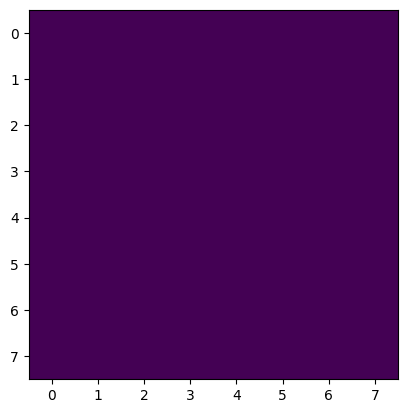

In [10]:
print(f"dKs diff:")
fig = plt.imshow(((dKs_cu - dKs_pt).abs() < BW_ATOL).squeeze().cpu().numpy())
dKs_cu, dKs_pt, (dKs_cu - dKs_pt).abs() < BW_ATOL

dVs diff:


(tensor([[[[ 1.0887, -0.4446,  0.4706, -0.3190,  0.4116, -1.8034,  0.0050,  0.0659],
           [-0.0421,  0.1563,  0.0617,  0.3007, -0.0698, -0.1000, -0.0538, -0.0444],
           [ 0.3124, -1.0277,  0.1419, -1.2843,  0.0986, -0.2473,  0.1642,  0.4936],
           [ 2.8332, -1.2277,  0.8285, -1.6066,  0.6202,  0.5162,  0.4254, -1.5510],
           [ 0.3252, -0.0265,  0.7425,  0.0939, -0.0332, -0.1595,  0.1494,  0.4908],
           [ 0.1775,  1.4343,  1.5645,  0.9326,  1.5448,  1.0952, -0.3111, -0.6306],
           [ 0.4850, -1.0719, -0.7489,  0.7876, -1.0324, -1.6715,  0.7666, -0.9760],
           [-0.3927, -0.0460, -0.1263, -0.3971,  0.0350,  0.1711, -0.4253,  0.6019]]]], device='cuda:0'),
 tensor([[[[ 1.0887, -0.4446,  0.4706, -0.3190,  0.4116, -1.8034,  0.0050,  0.0659],
           [-0.0421,  0.1563,  0.0617,  0.3007, -0.0698, -0.1000, -0.0538, -0.0444],
           [ 0.3124, -1.0277,  0.1419, -1.2843,  0.0986, -0.2473,  0.1642,  0.4936],
           [ 2.8332, -1.2277,  0.8285, -1.60

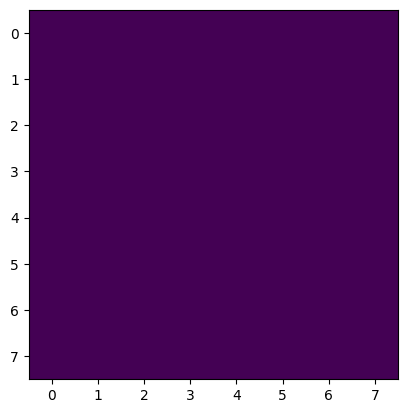

In [11]:
print(f"dVs diff:")
fig = plt.imshow(((dVs_cu - dVs_pt).abs() < BW_ATOL).squeeze().cpu().numpy())
dVs_cu, dVs_pt, (dVs_cu - dVs_pt).abs() < BW_ATOL

fw hs match: True, max dev: 2.384185791015625e-07
fw n match: True, max dev: 2.384185791015625e-07
fw m match: True, max dev: 2.384185791015625e-07
fw D match: True, max dev: 4.76837158203125e-07
delta Q match: True, max dev: 1.52587890625e-05
delta K match: True, max dev: 1.049041748046875e-05
delta V match: True, max dev: 2.6226043701171875e-06
delta Igate match: True, max dev: 9.059906005859375e-06
delta Fgate match: True, max dev: 1.3113021850585938e-06
mat R match: True, max dev: 1.7881393432617188e-07


(tensor([[[[ 1.1337,  1.4891,  4.3524, -0.9589, -0.8078, -1.0217, -0.8770, -1.7537],
           [ 0.1098, -0.0924,  0.0402, -0.3241,  0.0091,  0.1319, -0.0078,  0.0180],
           [ 0.0875, -0.3982, -0.7796, -0.4517,  0.2481,  0.6492, -0.0338,  0.4088],
           [-0.8733, -0.4610,  0.2411, -0.7859, -1.3191, -0.6446,  1.7476,  2.2800],
           [-0.2868, -0.2548, -0.7165, -0.3992, -0.3065, -0.1366,  0.5045,  0.6802],
           [-0.5910, -1.2418, -5.4582, -2.0970,  1.9743, -4.9774,  5.4871,  2.6867],
           [-0.0171,  0.3732,  0.4320, -0.2729,  0.6361, -0.8973, -0.0215,  0.6290],
           [ 0.6899,  0.4053,  0.6861, -1.1352, -0.3559, -0.1518, -0.5934,  1.3578]]]], device='cuda:0'),
 tensor([[[[ 1.1337,  1.4891,  4.3524, -0.9589, -0.8078, -1.0217, -0.8770, -1.7537],
           [ 0.1098, -0.0924,  0.0402, -0.3241,  0.0091,  0.1319, -0.0078,  0.0180],
           [ 0.0875, -0.3982, -0.7796, -0.4517,  0.2481,  0.6492, -0.0338,  0.4088],
           [-0.8733, -0.4610,  0.2411, -0.78

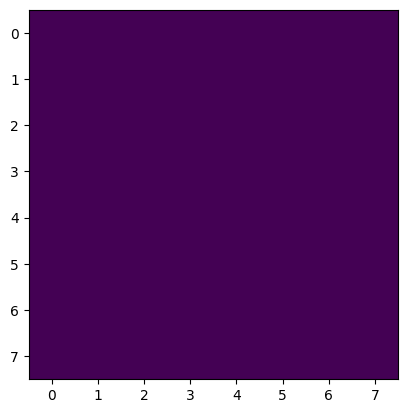

In [12]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"fw hs match: {torch.allclose(hs_cu2, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max dev: {torch.abs(hs_cu2 - hs_pt).max()}")
print(f"fw n match: {torch.allclose(n_cu2, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max dev: {torch.abs(n_cu2 - n_pt).max()}")
print(f"fw m match: {torch.allclose(m_cu2, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max dev: {torch.abs(m_cu2 - m_pt).max()}")
print(f"fw D match: {torch.allclose((matD_cu2 - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max dev: {torch.abs((matD_cu2 - matD_pt).tril()).max()}")

print(f"delta Q match: {torch.allclose(dQs_cu2, dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max dev: {torch.abs(dQs_cu2 - dQs_pt).max()}")
print(f"delta K match: {torch.allclose(dKs_cu2, dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max dev: {torch.abs(dKs_cu2 - dKs_pt).max()}")
print(f"delta V match: {torch.allclose(dVs_cu2, dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max dev: {torch.abs(dVs_cu2 - dVs_pt).max()}")
print(f"delta Igate match: {torch.allclose(dIgs_cu2, dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max dev: {torch.abs(dIgs_cu2 - dIgs_pt).max()}")
print(f"delta Fgate match: {torch.allclose(dFgs_cu2, dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max dev: {torch.abs(dFgs_cu2 - dFgs_pt).max()}")

print(f"mat R match: {torch.allclose(mat_R_pt, matC_cu2, rtol=BW_RTOL, atol=BW_ATOL)}, max dev: {torch.abs(mat_R_pt - matC_cu2).max()}")
plt.imshow(((dKs_cu - dKs_pt).abs() < BW_ATOL).squeeze().cpu().numpy())
dKs_cu, dKs_pt, (dKs_cu - dKs_pt).abs() < BW_ATOL

In [13]:
dKs_cu, dKs_cu2, dKs_pt

(tensor([[[[ 1.1337,  1.4891,  4.3524, -0.9589, -0.8078, -1.0217, -0.8770, -1.7537],
           [ 0.1098, -0.0924,  0.0402, -0.3241,  0.0091,  0.1319, -0.0078,  0.0180],
           [ 0.0875, -0.3982, -0.7796, -0.4517,  0.2481,  0.6492, -0.0338,  0.4088],
           [-0.8733, -0.4610,  0.2411, -0.7859, -1.3191, -0.6446,  1.7476,  2.2800],
           [-0.2868, -0.2548, -0.7165, -0.3992, -0.3065, -0.1366,  0.5045,  0.6802],
           [-0.5910, -1.2418, -5.4582, -2.0970,  1.9743, -4.9774,  5.4871,  2.6867],
           [-0.0171,  0.3732,  0.4320, -0.2729,  0.6361, -0.8973, -0.0215,  0.6290],
           [ 0.6899,  0.4053,  0.6861, -1.1352, -0.3559, -0.1518, -0.5934,  1.3578]]]], device='cuda:0'),
 tensor([[[[ 1.1337,  1.4891,  4.3524, -0.9589, -0.8078, -1.0217, -0.8770, -1.7537],
           [ 0.1098, -0.0924,  0.0402, -0.3241,  0.0091,  0.1319, -0.0078,  0.0180],
           [ 0.0875, -0.3982, -0.7796, -0.4517,  0.2481,  0.6492, -0.0338,  0.4088],
           [-0.8733, -0.4610,  0.2411, -0.78

In [14]:
from kernel_call_checks.multicall_fwbw import check_multi_kernel_calls_fwbw, check_multi_kernel_calls_fw

In [15]:
N = 100
check_multi_kernel_calls_fw(q=qs, k=ks, v=vs, ig=igs, fg=fgs, num_calls=N, atol=FW_ATOL, rtol=FW_RTOL)

  0%|          | 0/100 [00:00<?, ?it/s]

before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 8,

100%|██████████| 100/100 [00:00<00:00, 1904.62it/s]

before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 8,

In [16]:
N = 100
check_multi_kernel_calls_fwbw(dH=dHs,q=qs, k=ks, v=vs, ig=igs, fg=fgs, num_calls=N, atol=FW_ATOL, rtol=FW_RTOL)

  0%|          | 0/100 [00:00<?, ?it/s]

before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 8,

100%|██████████| 100/100 [00:00<00:00, 894.37it/s]

before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 8, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 8,